In [0]:
import numpy as np
import urllib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import models, optimizers
from keras import layers
from keras import regularizers
from keras.utils import to_categorical
%matplotlib inline



In [0]:
def load_crime_data():
  url = "http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

  raw_data = urllib.request.urlopen(url)

  dataset = np.genfromtxt(raw_data, dtype = 'float32', missing_values='?', delimiter=',')

  #Delete column for Community Name - String column.
  dataset = np.delete(dataset,3,1)
  
  #Convert column for State to Categorical
  col0_categorical = to_categorical(dataset[:,0])
  #Drop column 0 - will be replaced by categorical values
  dataset = np.delete(dataset,0,1)

  #Drop column 1,2 - Too many missing values
  dataset = np.delete(dataset,[0,1],1)

  #Separate predictors and target variable
  x_train, y_train = dataset[:,:-1], dataset[:,-1]

  #Append categorical tensor for state to x_train
  x_train = np.append(x_train, col0_categorical, axis = 1)
  
  #Column 26 has 1 missing value - Replace it with mean of that column
  x_train[np.where(np.isnan(x_train[:,26])), 26] = np.nanmean(x_train[:,26])
  
  #Delete Multiple columns with 1675 missing values
  del_cols = [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 117, 118, 119, 120, 122]
  x_train = np.delete(x_train, del_cols, 1)
  

  #Create Train and Test split  
  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)
  

  return (x_train, y_train), (x_test, y_test)

In [0]:
def define_model(num_layers = 1, num_neurons = [16], input_shape = (0,), optimizer_lr = 0, dropout = 0, regularizer = "L1", reg_rate = 0):
  
  assert input_shape[0] != 0
  assert num_layers == len(num_neurons)
  
  model = models.Sequential()
  
  for i in range(num_layers):
    if reg_rate:
      if regularizer == "L1":
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = regularizers.l1(reg_rate), activation = 'relu', input_shape = input_shape))
      else:
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = regularizers.l2(reg_rate), activation = 'relu', input_shape = input_shape))
    else:
      model.add(layers.Dense(num_neurons[i],  activation = 'relu', input_shape = input_shape))
      
    #Add dropout to all but the penultimate layer.
    if dropout and i < num_layers - 1:
      model.add(layers.Dropout(dropout))
    
  model.add(layers.Dense(1))
  
  if optimizer_lr:
    optimizer = optimizers.RMSprop(optimizer_lr)
  else:
    optimizer = optimizers.RMSprop()
  model.compile(optimizer = optimizer,
             loss = "mse",
             metrics = ["mae"])
  
  return model

In [0]:
def perform_kfold_cv(train_data, train_targets, 
                     k = 4, num_epochs = 200, batch_size = 128, 
                     num_layers = 1, num_neurons = [16], input_shape = (0,), 
                     optimizer_lr = 0, dropout = 0, regularizer = "L1", reg_rate = 0):

  all_mae_histories = []
  num_val_samples = len(train_data) // k
  for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = model = define_model(num_layers = num_layers, num_neurons = num_neurons, 
                                 input_shape = input_shape, optimizer_lr = optimizer_lr, 
                                 dropout = dropout, regularizer=regularizer, reg_rate = reg_rate)
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
  return all_mae_histories
  
  

In [0]:
def smooth_curves(points, factor = 0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [0]:
def print_graphs(all_mae_histories, epochs, smooth = 0):
  

  average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(epochs)]
  
  if smooth:
    average_mae_history = smooth_curves(average_mae_history[10:])

  plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
  plt.xlabel('Epochs')
  plt.ylabel('Validation MAE')
  plt.show()

In [0]:
## Load Data
(x_train, y_train), (x_test, y_test) = load_crime_data()

In [0]:
print(x_train.shape)
print(x_test.shape)

(1595, 158)
(399, 158)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


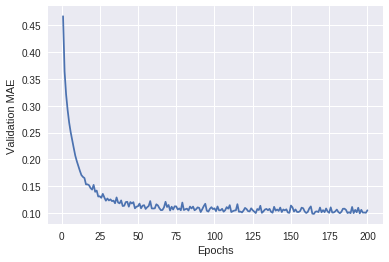

In [193]:
## Base Model
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 1, num_neurons = [8], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


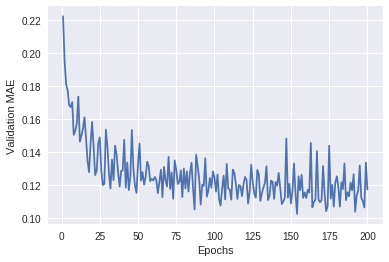

In [183]:
#Increasing size of layer
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 1, num_neurons = [32], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


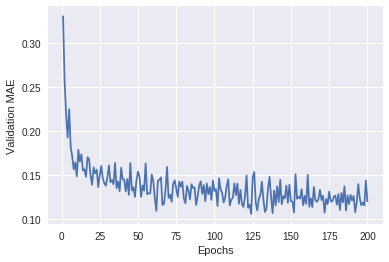

In [184]:
#Increasing size of layer
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 1, num_neurons = [64], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

**8 neurons seems to give the lowest Validation MAE. Testing with more layers.**

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


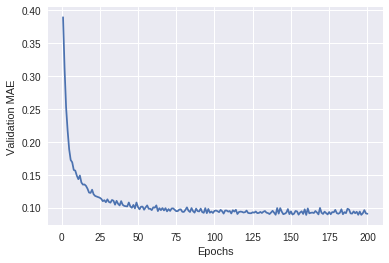

In [186]:
#Adding Layers
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


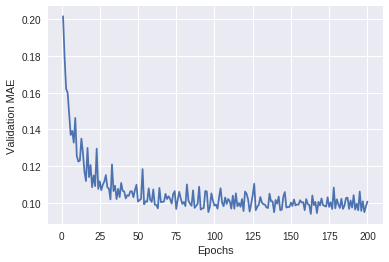

In [185]:
#Adding Layers
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [32, 8], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


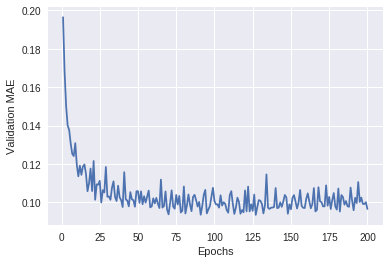

In [187]:
#Adding Layers
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [32, 32], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


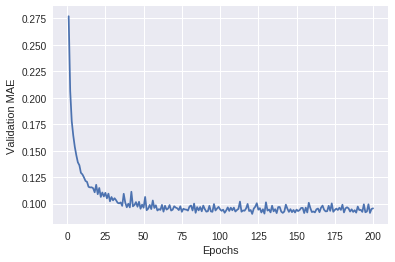

In [188]:
#Adding Layers
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [16, 8], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

In [ ]:
#2 Layers with size [8,8] gives a good fit

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


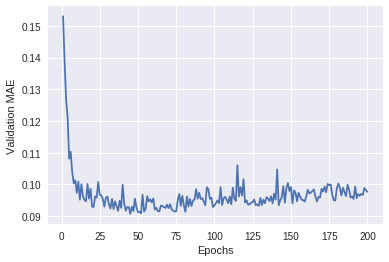

In [189]:
### Tuning Batch size
#Small Batch Size value of 16

epochs = 200
batch_size = 16

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


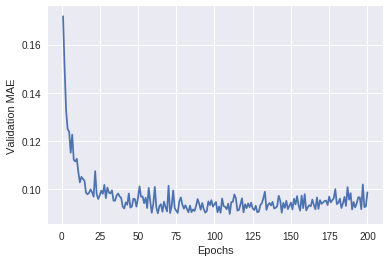

In [190]:
#Small Batch Size value of 128

epochs = 200
batch_size = 128

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


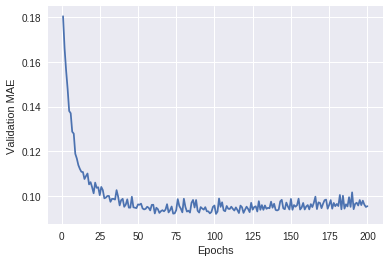

In [192]:
#Small Batch Size value of 256

epochs = 200
batch_size = 256

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],))
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

In [ ]:
##There is only a very slight improvement with a smaller batch size. Taking Batch size of 512 to increase training time.

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


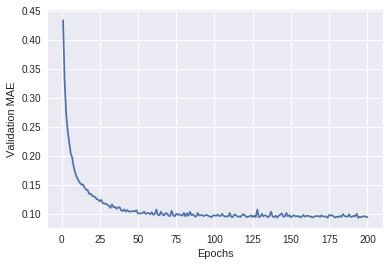

In [194]:
## Tuning Learning Rate
#Learning Rate = 0.001

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


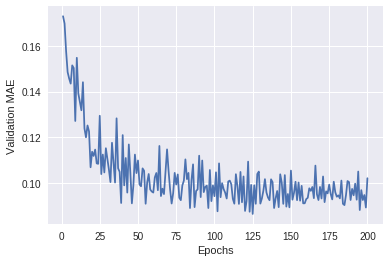

In [195]:
#Learning Rate = 0.01

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.01)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


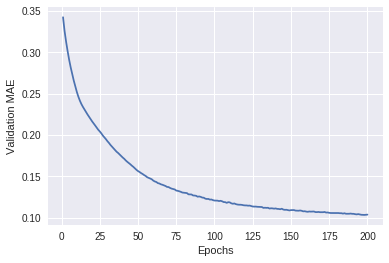

In [196]:
#Learning Rate = 0.0001

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.0001)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

In [ ]:
##Learning Rate of 0.001 gives a good performance.

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


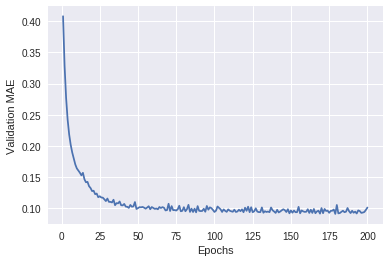

In [197]:
## Testing L1 Regularization
#Regularization Rate = 0.001

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L1", reg_rate = 0.001)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


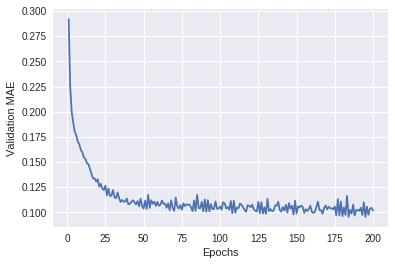

In [198]:
#Larger Regularization Rate = 0.005

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L1", reg_rate = 0.005)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


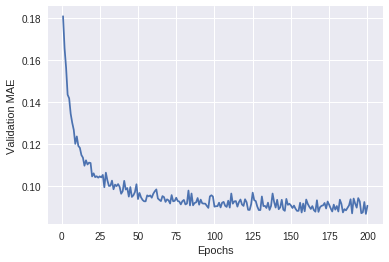

In [199]:
#Smaller Regularization Rate = 0.0005

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L1", reg_rate = 0.0005)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


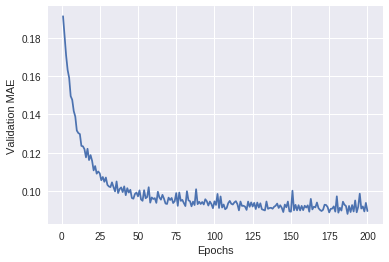

In [205]:
#Smaller Regularization Rate = 0.0001

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L1", reg_rate = 0.0001)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


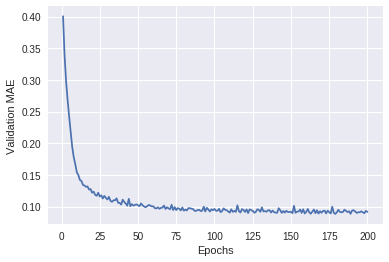

In [200]:
## L2 Regularization
#Regularization Rate = 0.001

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L2", reg_rate = 0.001)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


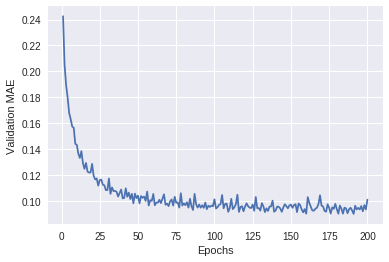

In [204]:
#Larger Regularization Rate = 0.005

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L2", reg_rate = 0.005)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


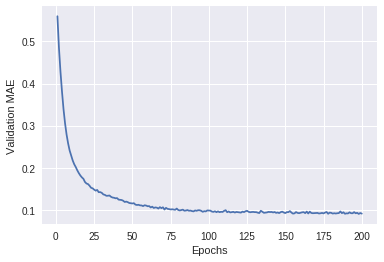

In [203]:
#Smaller Regularization Rate = 0.0005

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L2", reg_rate = 0.0005)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

In [ ]:
##L1 Regularization with a rate of 0.005 leads to the lowest Validation MAE

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


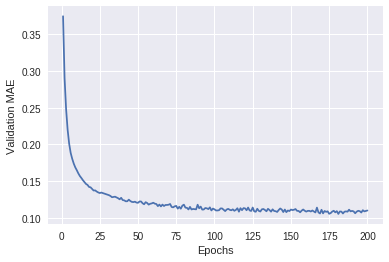

In [212]:
## Adding Dropout
epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L1", reg_rate = 0.0005, dropout = 0.5)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


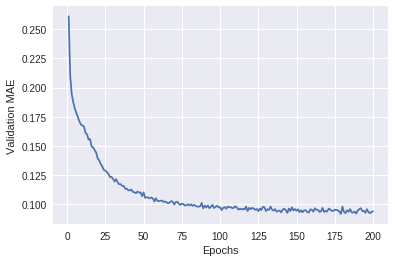

In [213]:
#Smaller Dropout value

epochs = 200
batch_size = 512

all_mae_histories = perform_kfold_cv(train_data = x_train, train_targets = y_train, 
                                     num_epochs = epochs, batch_size=batch_size, 
                                     num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L1", reg_rate = 0.0005, dropout = 0.2)
print_graphs(all_mae_histories = all_mae_histories, epochs = epochs, smooth = 0)

In [ ]:
#Dropout does not improve performance.
#Architecture:**
#Number of layers: 2
#Layer Size: [8, 8]
#Epochs: 200
#Batch_size = 512
#Regularization = L1
#Regularization Rate: 0.005
#Learning Rate: 0.001

In [222]:
### Final Model
epochs = 200
batch_size = 512

final_model = define_model(num_layers = 2, num_neurons = [8, 8], input_shape = (x_train.shape[1],), optimizer_lr = 0.001,
                                    regularizer="L1", reg_rate = 0.0005)
final_model.fit(x_train, y_train,
                   epochs = epochs,
                   batch_size = batch_size,
                   verbose = 0)

test_mse, test_mae = final_model.evaluate(x_test, y_test)

print(test_mae)



399/399 [==============================] - 4s 9ms/step
0.08737482533867198


In [0]:
final_model.save('AS1_Crime_model.h5')